In [1]:
%load_ext autoreload
%autoreload 2

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from shapely import geometry
from shapely.ops import unary_union
from shapely.geometry import Point
from descartes.patch import PolygonPatch
from skipper import tiling
from astropy import coordinates

In [117]:
def evaluate_coverage (frd, grid, poly_l, in_cosmos):
    RA,DEC = np.meshgrid ( frd.grid_ra, frd.grid_dec )

    in_cosmos = (RA >= (frd.center[0] - size[0]/2))&(RA <= (frd.center[0] + size[0]/2))
    in_cosmos &= (DEC >= (frd.center[1] - size[1]/2))&(DEC <= (frd.center[1] + size[1]/2))

    total_area_covered = unary_union(poly_l).area
    cy_l = []
    for ix,cnexp in enumerate([0, 10, 20, 30, 35, 39]):
        cy = (grid.sum(axis=0)[in_cosmos] > cnexp).sum()/in_cosmos.sum()   
        cy_l.append(cy)
    return total_area_covered, cy_l

In [120]:
def plot ( frd ):
    plt.figure(figsize=(8,6))
    ax = plt.subplot(111, aspect='equal')

    plt.pcolormesh(frd.grid_ra - np.diff(frd.grid_ra)[0]*.5, 
                   frd.grid_dec - np.diff(frd.grid_dec)[0]*.5, 
                   grid.sum(axis=0), vmax=40, vmin=0)

    rect = patches.Rectangle ( [frd.center[0] - size[0]/2, frd.center[1] - size[1]/2],
                              width = size[0], 
                              height= size[1],
                             fc='None', ec='w', )
    ax.add_patch (rect)
    #ax.text ( .95, 0.95, r'$\Delta$R=%.2f deg' % (radii_a[ix]*size[0]), ha='right', va='top', color='white', 
    #        fontsize=20, transform=ax.transAxes )
    plt.colorbar(label=r'$\rm N_{exp}$')
    ax.set_xlabel('RA (deg)')
    ax.set_ylabel ( "Dec (deg)")

    #plt.savefig(f'../../scratch/figs/{ix:04d}.png')
    #plt.close()


In [30]:
# \\ COSMOS region
center = coordinates.SkyCoord ("10h00m28.6s+02d12m21.0s")
size =  (1.4, 1.4)

edges = [ (center.ra.deg-size[0]/2., center.dec.deg-size[0]/2.),
          (center.ra.deg+size[0]/2., center.dec.deg-size[0]/2.),
          (center.ra.deg+size[0]/2., center.dec.deg+size[0]/2.),
          (center.ra.deg-size[0]/2., center.dec.deg+size[0]/2.) ]
cosmos_area = geometry.Polygon ( edges )

In [123]:
or_l = np.linspace(0., 0.125,15)
tac_a = np.zeros ( len(or_l) )
cy_a = np.zeros ( [len(or_l), 6] )

for ix,cor in enumerate(or_l):
    frd = tiling.FocusedRandomDither (center, offset_radius=cor)
    frd._make_grid ()

    grid, poly_l, area_a, centers = frd.compute_coverage ( cosmos_area )
    tac, cy_l = evaluate_coverage ( frd, grid, poly_l, in_cosmos )
    
    tac_a[ix] = tac
    cy_a[ix] = cy_l
    plot(frd)
    plt.savefig(f'../../scratch/figs/RD{ix:04d}.png')
    plt.close()

In [138]:
plt.rcParams['font.size'] = 20

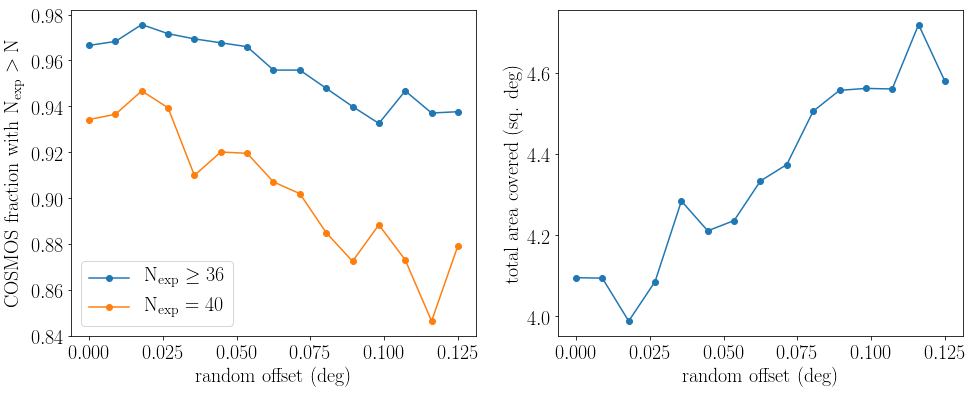

In [145]:
fig, axarr = plt.subplots(1,2, figsize=(16,6))
axarr[0].plot ( or_l, cy_a[:,-2], 'o-', label=r'$\rm N_{exp} \geq$ 36' )
axarr[0].plot ( or_l, cy_a[:,-1], 'o-', label=r'$\rm N_{exp} =$ 40' )

axarr[1].plot ( or_l, tac_a, 'o-' )

for ax in axarr:
    ax.set_xlabel ('random offset (deg)' )
    
axarr[0].legend ()
axarr[0].set_ylabel (r'COSMOS fraction with $\rm N_{exp}>N$')
axarr[1].set_ylabel ( 'total area covered (sq. deg)' )
plt.savefig('../../scratch/FDRcoverage.png')

Text(0,0.5,'Dec (deg)')

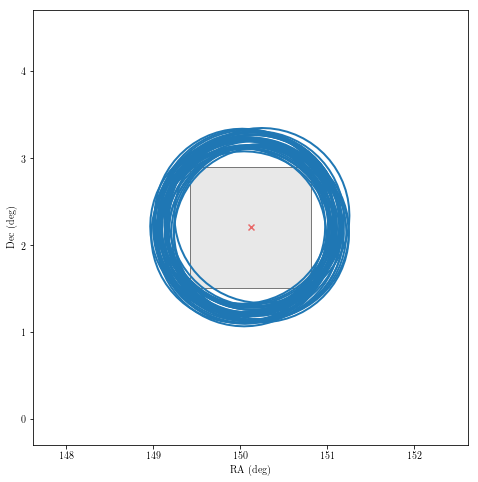

In [74]:
fig = plt.figure ( figsize=(8,8))
ax = plt.subplot(111, aspect='equal')
rect = patches.Rectangle ( [center.ra.deg - size[0]/2, center.dec.deg - size[1]/2],
                          width = size[0], 
                          height= size[1],
                         fc='lightgrey', ec='k', alpha=0.5)
ax.add_patch (rect)

for ij in range(frd.ndither):
    patch = PolygonPatch ( poly_l[ij], fc='None', ec='tab:blue', lw=2, )
    ax.add_patch(patch)
    
ax.scatter ( *frd.center, color='r', marker='x')

ax.set_xlim ( center.ra.deg - 2.5,  center.ra.deg  + 2.5)
ax.set_ylim ( center.dec.deg- 2.5,  center.dec.deg + 2.5)

ax.set_xlabel ( 'RA (deg)')
ax.set_ylabel ('Dec (deg)')